# Orientation estimation based on local region

We hope to use the local region estimation instead of whole image, which may be infulenced by the noise or other things.

# Background
In the previous experiments, we using the gradients histogram and points matching method to estimate the orientation of images.
But the previous experiments is based on the whole imgaes, which results in pretty much problems.
Therefore in this paper we propose the new method that apply the previous estimation method in the local region of tested images.

With the development of deep learning technology the multi-object detection has great technological breakthroughs.
The convolutional neural network can predict the objects position and classification exactly.
With the parallel calculation hardware the detection method can run in the real time.

In [5]:
import time
import numpy as np
import cv2
import torch

from utils.datasets import letterbox
from utils.models import *
#from Utils_orientation import object_detection, object_capture
#from Utils_orientation import angle_HoG, HoG_cal, angle_cal

# Image path
base_file = "figures/71.jpg"
rotate_file = "figures/99.jpg"

# Configuration file path
cfg = 'cfg/yolov3-spp.cfg'
data_cfg = 'cfg/coco.data'
weights = 'cfg/yolov3-spp.pt'
data ='cfg/coco.data'

# Model parameter
img_size=640
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

# Initialize model and load weights
model = Darknet(cfg, img_size)
model.load_state_dict(torch.load(weights, map_location=device)['model'])
model.to(device).eval()

print("The model has ready")

The model has ready


<font face='Ubuntu' size = 4>
    
## The object detection function

All the function is based on the YOLO algorithm.

1. `object_detection`: intput the image or file name and return position vector
2. `object_capture`: intput two file names and return two partial images of same object

In [6]:
def object_detection(model, img_file, conf_thres = 0.5):
    """
    This is a Object detection function using CNN.

    Parameters:
        model: The YOLO darknet model
        img_file: image file path the pre and post processing is in the function

    Returns:
        The scalable detection parameter which is top_left and bottom_right corner
        And the confidence and classification confidence
    """
    nms_thres = 0.5
    # Preprocess the image

    start_time = time.time()
    if isinstance(img_file, str):
        img0 = cv2.imread(img_file)
    else:
        img0 = img_file
    # Padded resize
    img, _, _, _, _ = letterbox(img0)
    # Normalize RGB
    img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB
    img = np.ascontiguousarray(img, dtype=np.float32)  # uint8 to float32
    img /= 255.0  # 0 - 255 to 0.0 - 1.0

    imgpreprocess_time = time.time() - start_time
    # Get detections
    img = torch.from_numpy(img).unsqueeze(0).to(device)
    with torch.no_grad():
        pred, _ = model(img)
    # NMS 
    detections = non_max_suppression(pred, conf_thres, nms_thres)[0]
    detection_time = time.time() - start_time - imgpreprocess_time
    # Rescale the detection into original size
    scale_coords(img.shape[2:], detections[:, :4], img0.shape).round()
    reject_time = time.time() - start_time  - imgpreprocess_time - detection_time

    print("The whole process time: {0:.4f}s = {1:.4f}s + {2:.4f}s + {3:.4f}s"\
          .format(time.time() - start_time, imgpreprocess_time, detection_time, reject_time))
    return detections

def object_capture(base_file, rotate_file, detection_index = 0,
                   detection_base = None, detection_rotate = None):
    
    
    if detection_base is None:
        img_base = cv2.imread(base_file)
        img_rotate = cv2.imread(rotate_file)
    else:
        
        inter_class = np.intersect1d(detection_rotate[:, 6], detection_base[:, 6])
        detection_index = np.where(detection_base[:, 6] == inter_class[0])
        
        print(detection_index)
        
        if isinstance(base_file, str):
            img_base = cv2.imread(base_file)
            img_rotate = cv2.imread(rotate_file)
        else:
            img_base = base_file
            img_rotate = rotate_file
        # Finding the corresponding object
        object_index = np.where(detection_rotate[:, 6] == detection_base[detection_index, 6])
        # Base image capture
        x1, y1, x2, y2 = np.uint64(detection_base[detection_index, 0:4])
        img_base = img_base[y1:y2, x1:x2, :]
        # Rotate image capture
        x1, y1, x2, y2 = np.uint64(detection_rotate[object_index, 0:4].squeeze())
        img_rotate = img_rotate[y1:y2, x1:x2, :]

    return img_base, img_rotate


# This operation is for the later timing accuracy
stupid_predict = object_detection(model, "figures/dog.jpg")

The whole process time: 0.0450s = 0.0096s + 0.0345s + 0.0010s


<font face='Ubuntu' size = 4>
    
## Gradient Histogram orientation estimation Methods

Maybe we need do some modification here.

In [3]:
def HoG_cal(img, mag_thres = 50, bin_num = 360):
    '''
    Calculation the histogram of gradients direction
    '''
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Cal the magnitude and angle of Gradients
    sobelx=cv2.Sobel(img, cv2.CV_64F, dx=1, dy=0)
    sobely=cv2.Sobel(img, cv2.CV_64F, dx=0, dy=1)
    gradient = np.arctan2(sobely, sobelx) * 180 / np.pi
    magnitude = np.sqrt(sobelx ** 2 + sobely ** 2)

    # Set one Threshold which discard the low identity gradient
    #mag_thres = magnitude.max() / 2
    mag_sort = np.sort(magnitude.flatten())
    mag_thres = mag_sort[int(len(mag_sort) * 0.99)]
    plt.figure()
    plt.plot(mag_sort)
    plt.plot(int(len(mag_sort) * 0.995), mag_thres, 'ro', linewidth = 10)
    plt.show()
    
    gradient = (magnitude > mag_thres) * gradient
    gradient = (gradient < 0) * 360 + gradient
    hist, bins = np.histogram(gradient, bin_num)
    hist = hist[1:]
    
    return hist

def angle_HoG(base_HoG, rotate_HoG, limits = 10):
    '''
    Calculation the translation value of two hists
    '''
    m = base_HoG.shape[0]
    
    error = np.array([])
    for i in range(-limits, limits + 1):
        base_begin = max(0, i)
        base_end = min(m, m + i)

        rotate_begin = max(0, -i)
        rotate_end = min(m, m - i)

        base_line = base_HoG[base_begin:base_end]
        rotate_line = rotate_HoG[rotate_begin:rotate_end]

        error = np.append(error, np.mean((base_line - rotate_line) **2))

    angle = np.argmin(error) - limits
    
    return angle

<font face='Ubuntu' size = 4>
    
# Simulation


<font face='Ubuntu' size = 4>
    
## Real images with unknown angle

In [4]:
from Utils_orientation import angle_cal

base_file = "figures/71.jpg"
rotate_file = "figures/99.jpg"
base_file = "figures/real_experiment/00.jpeg"
rotate_file = "figures/real_experiment/04.jpeg"

start = time.time()
# Detection Process Transform tensor into numpy array
if device == torch.device("cpu"):
    detection_base = object_detection(model, base_file).numpy()
    detection_rotate = object_detection(model, rotate_file).numpy()
else:
    detection_base = object_detection(model, base_file, conf_thres= 0.05).cpu().numpy()
    detection_rotate = object_detection(model, rotate_file, conf_thres= 0.05).cpu().numpy()
print("Detection time comsuming: {0:.4f}".format(time.time() - start))

print(detection_base)
print(detection_rotate)

The whole process time: 0.1718s = 0.1406s + 0.0312s + 0.0000s
The whole process time: 0.1729s = 0.1416s + 0.0312s + 0.0000s
Detection time comsuming: 0.3603
[[          0      1744.6      458.53      3041.9     0.19877     0.99008           0]
 [     1793.5      2444.3        2699      3592.1     0.11582     0.69728          62]
 [          0      1761.1      493.34      2216.3    0.095935     0.72788           0]
 [     1258.8      3364.9      1827.3      3710.6    0.051484     0.53294          39]]
[[          0      1675.9      489.21      2107.5     0.16046     0.73468           0]
 [     1638.8      2463.9      2605.6      3676.8    0.083605     0.64034          62]
 [     2429.2      1555.4        3024      1904.4    0.065051     0.35358          39]
 [     1121.6      3337.7      1695.7      3731.2    0.063552     0.73417          39]
 [          0      1592.6      460.52      2943.5    0.050234     0.99015           0]]


In [11]:
inter_class = np.intersect1d(detection_rotate[:, 6], detection_base[:, 6])
print(type(inter_class), inter_class.shape)
detection_index = np.where(detection_base[:, 6] == inter_class[0])

print(type(detection_index))
print(inter_class, detection_index)

detection_index = np.where(detection_base[:, 6] == inter_class[1])
print(inter_class, detection_index)

a = np.uint64(detection_base[detection_index[0][0], 0:4])
b = np.uint64(detection_base[0, 0:4])
print(type(a), a.shape)
print(type(b), b.shape)
#[x1, y1, x2, y2] = np.uint64(detection_base[detection_index[0], 0:4])

<class 'numpy.ndarray'> (3,)
<class 'tuple'>
[          0          39          62] (array([0, 2], dtype=int64),)
[          0          39          62] (array([3], dtype=int64),)
<class 'numpy.ndarray'> (4,)
<class 'numpy.ndarray'> (4,)


In [13]:
c = torch.zeros((3, 3))
print(c)

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])


The whole process time: 0.1745s = 0.1456s + 0.0279s + 0.0010s
The whole process time: 0.1735s = 0.1456s + 0.0259s + 0.0020s
time is 0.0120
tensor([[2, 0]], device='cuda:1')
tensor([[0.00000, 0.00000],
        [0.00000, 0.00000],
        [0.30584, 0.00000],
        [0.00000, 0.00000]], device='cuda:1')
(455, 493, 3) (428, 505, 3)


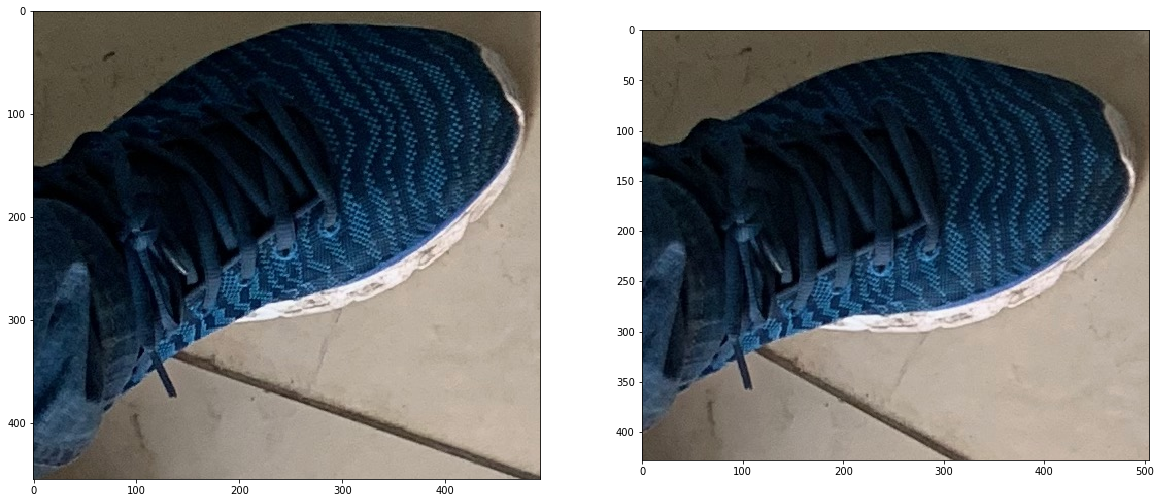

In [21]:
from utils.utils import bbox_iou
import time
import matplotlib.pyplot as plt
def boxes_match(detection_base, detection_rotate):
    iou_thres = 0.3
    wh_ratio_thres = 0.2
    start = time.time()
    iou_list = []
    iou_value = torch.zeros(detection_base.shape[0], detection_rotate.shape[0]).to(device)
    class_match = torch.zeros(detection_base.shape[0], detection_rotate.shape[0]).to(device)
    for i, box_base in enumerate(detection_base):
        for j, box_rotate in enumerate(detection_rotate):
            if box_base[6] == box_rotate[6]:
                class_match[i, j] = 1         
            iou = bbox_iou(box_base[0:4], box_rotate[0:4])
            box_ratio_base = (box_base[3] - box_base[1]) / (box_base[2] - box_base[0])
            box_ratio_rotate = (box_rotate[3] - box_rotate[1]) / (box_rotate[2] - box_rotate[0])
            wh_ratio = box_ratio_base / box_ratio_rotate
            if iou > iou_thres and (wh_ratio > 1 - wh_ratio_thres and wh_ratio < 1 + wh_ratio_thres):
                iou_list.append((i, j))
                iou_value[i, j] = iou
                #print(wh_ratio)
    print("time is {0:.4f}".format(time.time() - start))
    
    matching_box = iou_value * class_match
    
    box_index = torch.nonzero(matching_box)
    print(box_index)
    print(matching_box)
    
    
    return box_index

base_file = "figures/dog.jpg"
rotate_file = "figures/dog_rotate.jpg"

base_file = "figures/real_experiment/00.jpeg"
rotate_file = "figures/real_experiment/10.jpeg"
detection_base = object_detection(model, base_file, conf_thres= 0.05)
detection_rotate = object_detection(model, rotate_file, conf_thres= 0.05)

box_index = boxes_match(detection_base, detection_rotate)

img_base = cv2.imread(base_file)
img_rotate = cv2.imread(rotate_file)

img_base = cv2.cvtColor(img_base, cv2.COLOR_BGR2RGB)
img_rotate = cv2.cvtColor(img_rotate, cv2.COLOR_BGR2RGB)

for detection_index in box_index:
    plt.figure(figsize= [20, 10])
    x1, y1, x2, y2 = np.uint64(detection_base[detection_index[0], 0:4].cpu())
    img_base_clip = img_base[y1:y2, x1:x2, :]
    x1, y1, x2, y2 = np.uint64(detection_rotate[detection_index[1], 0:4].cpu())
    img_rotate_clip = img_rotate[y1:y2, x1:x2, :]
    print(img_base_clip.shape, img_rotate_clip.shape)
    
    
    plt.subplot(1, 2, 1)
    plt.imshow(img_base_clip)
    plt.subplot(1, 2, 2)
    plt.imshow(img_rotate_clip)
    plt.show()

In [9]:
from Utils_orientation import angle_cal

base_file = "figures/71.jpg"
rotate_file = "figures/99.jpg"

start = time.time()
# Detection Process Transform tensor into numpy array
if device == torch.device("cpu"):
    detection_base = object_detection(model, base_file).numpy()
    detection_rotate = object_detection(model, rotate_file).numpy()
else:
    detection_base = object_detection(model, base_file).cpu().numpy()
    detection_rotate = object_detection(model, rotate_file).cpu().numpy()
print("Detection time comsuming: {0:.4f}".format(time.time() - start))

# Image Orientation Calculation
show_results = False
show_images = False
mode = "ORB"
# The index of object using to calculation the capture image
detection_index = 1

img_base, img_rotate = object_capture(base_file, rotate_file, detection_index = detection_index,
                   detection_base = detection_base, detection_rotate = detection_rotate)
print("Detection time comsuming: {0:.4f}".format(time.time() - start))
hist_base = HoG_cal(img_base)
hist_rotate = HoG_cal(img_rotate)
Hog_angle = angle_HoG(hist_base, hist_rotate)
print("The HoG result is {0:2d} in {1:.4f}".format(Hog_angle, time.time() - start))

median, mean, angle_time = angle_cal(img_base, img_rotate, mode, show_results= show_results, show_images= show_images)
print(mode + "real Result: median({0:6.3f}), mean({1:6.3f}) in {2:.3f}".format(median, mean, angle_time))

The whole process time: 0.0150s = 0.0041s + 0.0105s + 0.0003s
The whole process time: 0.0143s = 0.0040s + 0.0099s + 0.0003s
Detection time comsuming: 0.0299
(array([1]),)


ValueError: not enough values to unpack (expected 4, got 1)

<font face='Ubuntu' size = 4>
    
## Manual images

The whole process time: 0.0118s = 0.0024s + 0.0091s + 0.0003s
The whole process time: 0.0122s = 0.0025s + 0.0094s + 0.0003s
The Detection vector is
[[     209.81        35.4      258.94      83.744     0.73874     0.99675          64]
 [     415.97           0         640      207.69     0.62668     0.82092          24]
 [     115.45      60.119      458.47       347.7     0.52595      0.9524          63]]
[[     208.53      36.719       258.2      84.941     0.86327     0.99832          64]
 [     417.39     0.55536         640      199.75     0.64189     0.83423          24]]
The clipping image size is :(48, 49) (48, 50)


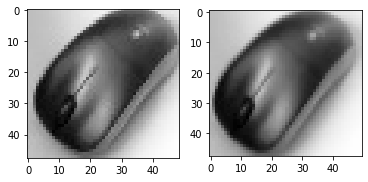

FD Rotate(1.0):mean(0.911), median(0.911) in 0.002


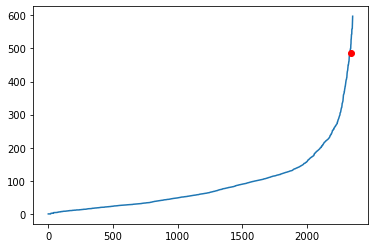

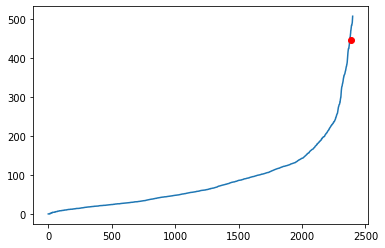

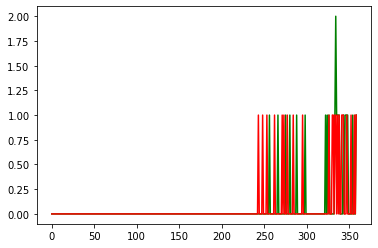

The HoG estimation when (1.0) is  4 in 0.4294s
----------------------------------------------------------------------------------------------------
The whole process time: 0.0118s = 0.0024s + 0.0091s + 0.0003s
The whole process time: 0.0116s = 0.0024s + 0.0089s + 0.0003s
The Detection vector is
[[     209.81        35.4      258.94      83.744     0.73874     0.99675          64]
 [     415.97           0         640      207.69     0.62668     0.82092          24]
 [     115.45      60.119      458.47       347.7     0.52595      0.9524          63]]
[[     205.35      37.714      255.41      85.837     0.94902     0.99911          64]
 [     417.76      1.3104         639      197.19     0.63622     0.82521          24]]
The clipping image size is :(48, 49) (48, 50)


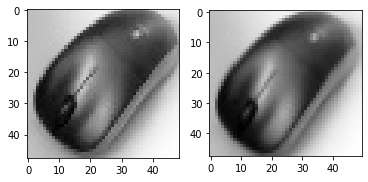

FD Rotate(2.0):mean(2.766), median(1.693) in 0.002


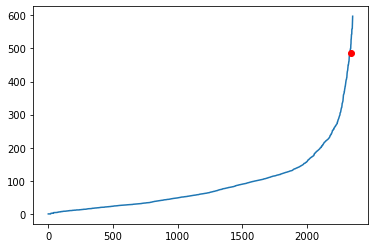

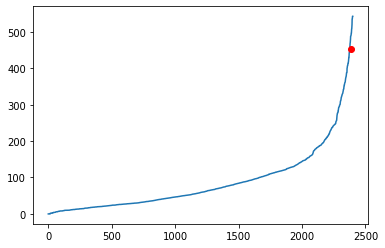

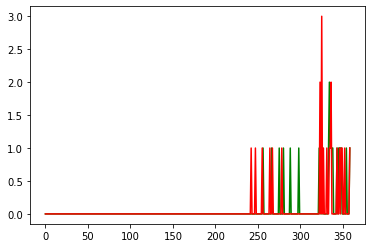

The HoG estimation when (2.0) is 11 in 0.4016s
----------------------------------------------------------------------------------------------------
The whole process time: 0.0129s = 0.0024s + 0.0102s + 0.0003s
The whole process time: 0.0128s = 0.0024s + 0.0101s + 0.0003s
The Detection vector is
[[     209.81        35.4      258.94      83.744     0.73874     0.99675          64]
 [     415.97           0         640      207.69     0.62668     0.82092          24]
 [     115.45      60.119      458.47       347.7     0.52595      0.9524          63]]
[[     203.19      38.785      253.97      87.531     0.92863     0.99823          64]
 [     413.96      2.3908         640      194.67      0.6599      0.7823          24]]
The clipping image size is :(48, 49) (49, 50)


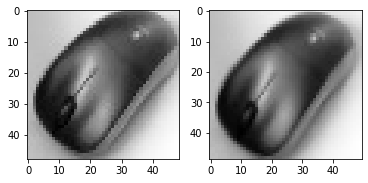

FD Rotate(3.0):mean(3.520), median(2.500) in 0.002


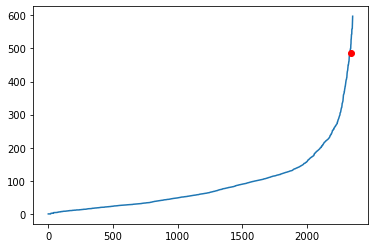

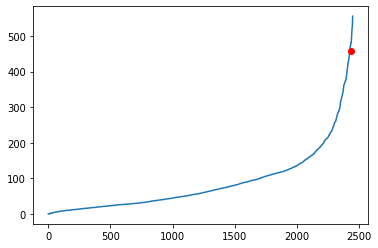

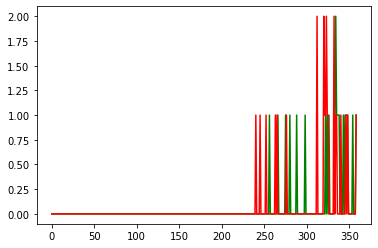

The HoG estimation when (3.0) is 14 in 0.4106s
----------------------------------------------------------------------------------------------------
The whole process time: 0.0130s = 0.0024s + 0.0103s + 0.0003s
The whole process time: 0.0129s = 0.0024s + 0.0101s + 0.0003s
The Detection vector is
[[     209.81        35.4      258.94      83.744     0.73874     0.99675          64]
 [     415.97           0         640      207.69     0.62668     0.82092          24]
 [     115.45      60.119      458.47       347.7     0.52595      0.9524          63]]
[[     203.05      40.814       251.9      89.811      0.9342     0.99839          64]
 [     412.11      1.6311      639.83      192.67     0.65133     0.73112          24]]
The clipping image size is :(48, 49) (49, 48)


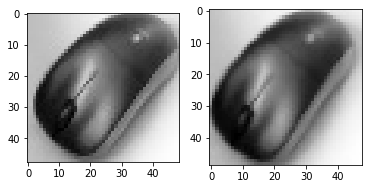

FD Rotate(4.0):mean(5.267), median(5.267) in 0.002


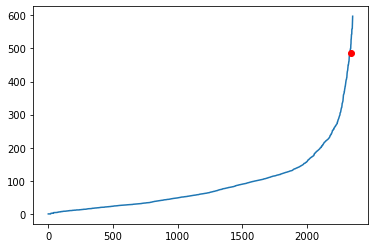

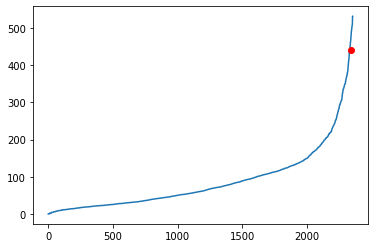

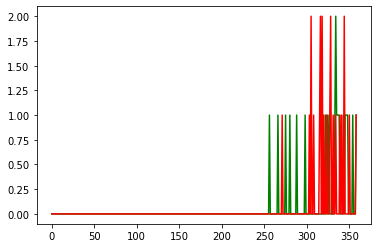

The HoG estimation when (4.0) is  6 in 0.4268s
----------------------------------------------------------------------------------------------------
The whole process time: 0.0129s = 0.0023s + 0.0102s + 0.0003s
The whole process time: 0.0127s = 0.0024s + 0.0100s + 0.0003s
The Detection vector is
[[     209.81        35.4      258.94      83.744     0.73874     0.99675          64]
 [     415.97           0         640      207.69     0.62668     0.82092          24]
 [     115.45      60.119      458.47       347.7     0.52595      0.9524          63]]
[[     201.34      41.078      250.07      92.913      0.9342     0.99838          64]
 [     408.66      1.5215       639.2      190.64     0.66464     0.75152          24]]
The clipping image size is :(48, 49) (51, 49)


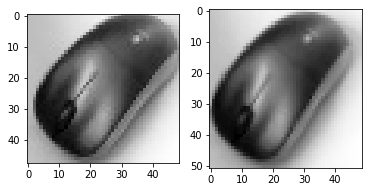

FD Rotate(5.0):mean(6.128), median(6.987) in 0.002


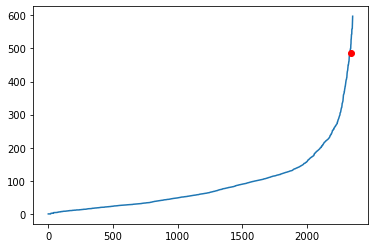

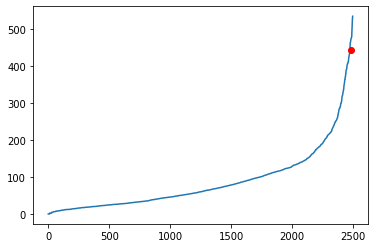

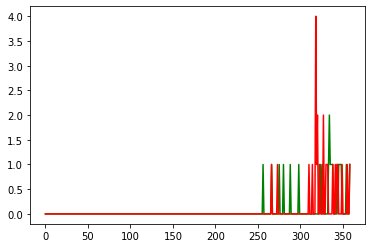

The HoG estimation when (5.0) is 15 in 0.4114s
----------------------------------------------------------------------------------------------------
The whole process time: 0.0129s = 0.0023s + 0.0102s + 0.0003s
The whole process time: 0.0129s = 0.0024s + 0.0101s + 0.0003s
The Detection vector is
[[     209.81        35.4      258.94      83.744     0.73874     0.99675          64]
 [     415.97           0         640      207.69     0.62668     0.82092          24]
 [     115.45      60.119      458.47       347.7     0.52595      0.9524          63]]
[[     198.69      41.941      248.45          96     0.85771     0.99715          64]
 [     413.15      4.8517      633.34      181.56     0.61103     0.72197          24]]
The clipping image size is :(48, 49) (55, 50)


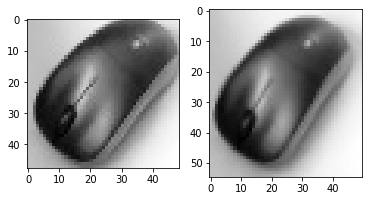

FD Rotate(6.0):mean(7.765), median(7.765) in 0.002


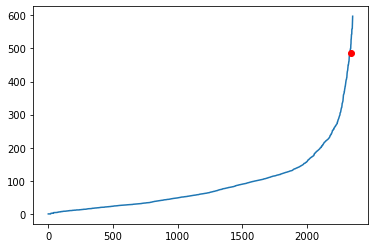

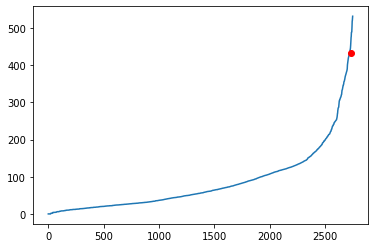

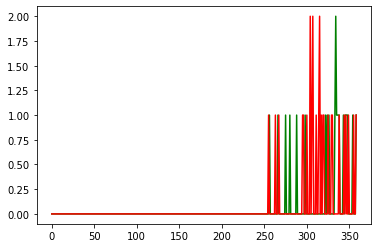

The HoG estimation when (6.0) is 15 in 0.4127s
----------------------------------------------------------------------------------------------------
The whole process time: 0.0130s = 0.0024s + 0.0102s + 0.0003s
The whole process time: 0.0127s = 0.0024s + 0.0100s + 0.0003s
The Detection vector is
[[     209.81        35.4      258.94      83.744     0.73874     0.99675          64]
 [     415.97           0         640      207.69     0.62668     0.82092          24]
 [     115.45      60.119      458.47       347.7     0.52595      0.9524          63]]
[[     197.72      45.379       244.2      96.178     0.92824     0.99644          64]
 [     407.75      3.5565      634.14       180.4       0.618     0.71062          24]]
The clipping image size is :(48, 49) (51, 47)


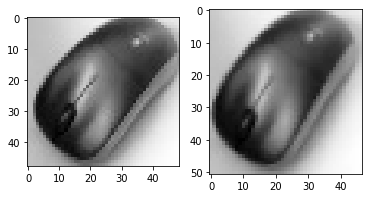

FD Rotate(7.0):mean(8.298), median(8.298) in 0.002


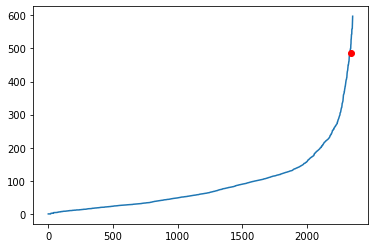

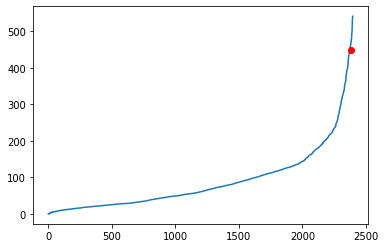

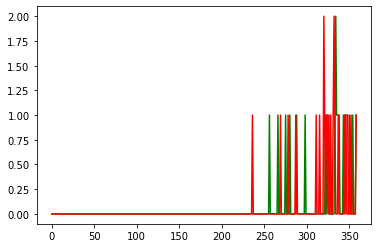

The HoG estimation when (7.0) is 14 in 0.4336s
----------------------------------------------------------------------------------------------------
The whole process time: 0.0130s = 0.0024s + 0.0103s + 0.0003s
The whole process time: 0.0125s = 0.0024s + 0.0097s + 0.0004s
The Detection vector is
[[     209.81        35.4      258.94      83.744     0.73874     0.99675          64]
 [     415.97           0         640      207.69     0.62668     0.82092          24]
 [     115.45      60.119      458.47       347.7     0.52595      0.9524          63]]
[[     195.76      46.295      241.63      97.143     0.96924     0.99727          64]]
The clipping image size is :(48, 49) (51, 46)


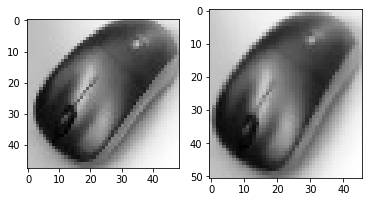

FD Rotate(8.0):mean(8.522), median(8.522) in 0.002


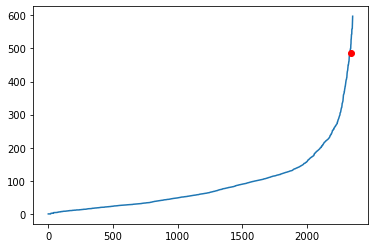

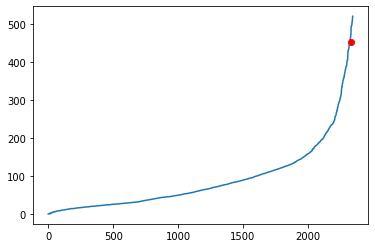

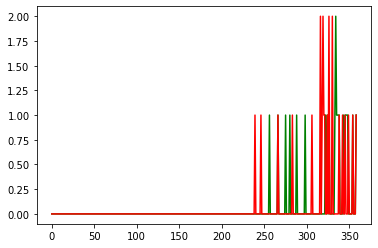

The HoG estimation when (8.0) is 15 in 0.4057s
----------------------------------------------------------------------------------------------------
[   0.088908     0.76601     0.51968      1.2675      1.1277      1.7647      1.2983     0.52151]


In [5]:
import matplotlib.pyplot as plt

base_file = 'figures/71.jpg'

img_orig = cv2.imread(base_file)
(h, w, d) = img_orig.shape
center = (w / 2, h / 2)
detection_index = 0

errors = np.array([])

for rotate_angle in range(1, 9):
    M = cv2.getRotationMatrix2D(center, rotate_angle, 1)
    img_rotate = cv2.warpAffine(img_orig, M, (w, h))
    start = time.time()
    detection_base = object_detection(model, img_orig).cpu().numpy()
    detection_rotate = object_detection(model, img_rotate).cpu().numpy()
    
    print("The Detection vector is")
    print(detection_base)
    print(detection_rotate)
    
    img_base, img_rotate = object_capture(img_orig, img_rotate, detection_index = detection_index,
                   detection_base = detection_base, detection_rotate = detection_rotate)
    img_base = cv2.cvtColor(img_base, cv2.COLOR_BGR2GRAY)
    img_rotate = cv2.cvtColor(img_rotate, cv2.COLOR_BGR2GRAY)
    print("The clipping image size is ", end = ':')
    print(img_base.shape, img_rotate.shape)
    
    
    plt.subplot(1, 2, 1)
    plt.imshow(img_base, cmap= 'Greys_r')
    plt.subplot(1, 2, 2)
    plt.imshow(img_rotate, cmap= 'Greys_r')
    plt.show()
    
    mode = "SIFT"
    fd_median, fd_mean, exe_time = angle_cal(img_base, img_rotate, mode, show_results= show_results, show_images= show_images)
    print("FD Rotate({0:3.1f}):mean({1:5.3f}), median({2:5.3f}) in {3:.3f}".format(rotate_angle, fd_mean, fd_median, exe_time))
    
    errors = np.append(errors, abs(rotate_angle - fd_mean))
    
    bins = 360
    thres = 150
    # The translation angles
    angle_limits = 15
    
    hist_base = HoG_cal(img_base, mag_thres= thres, bin_num= bins)
    hist_rotate = HoG_cal(img_rotate, mag_thres= thres, bin_num= bins)
    plt.plot(hist_base, 'g', label = 'Orientation Historgram of Original Image')
    plt.plot(hist_rotate, 'r', label = 'Orientation Historgram of Rotate Image')
    plt.show()
    # Using HoG to calculate the angel
    angle = angle_HoG(hist_base, hist_rotate, limits = angle_limits)
    print("The HoG estimation when ({0:.1f}) is {1:2d} in {2:.4f}s" \
        .format(rotate_angle ,angle, time.time() - start))
    
    print("-" * 100)
    
print(errors)

<font face='Ubuntu' size = 4>

## Noise images

The whole process time: 0.0125s = 0.0024s + 0.0097s + 0.0003s
The whole process time: 0.0128s = 0.0024s + 0.0100s + 0.0003s
The Detection vector is
[[     211.24       35.37      261.66      83.198     0.93894      0.9988          64]]
[[     208.47      36.983      259.58      84.364     0.79655     0.99846          64]]
The clipping image size is :(48, 50) (48, 51)


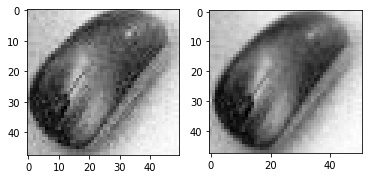

FD Rotate(1.0):mean(1.017), median(1.017) in 0.002


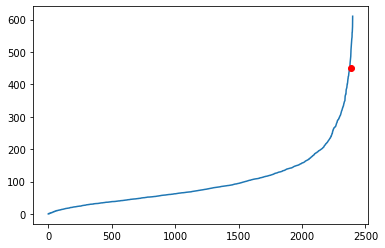

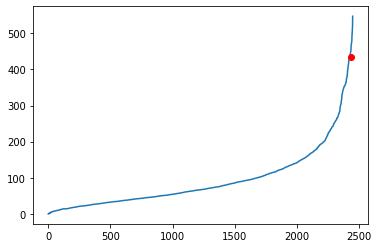

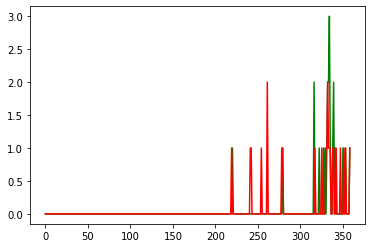

The HoG estimation when (1.0) is  0 in 0.4217s
----------------------------------------------------------------------------------------------------
The whole process time: 0.0126s = 0.0024s + 0.0098s + 0.0003s
The whole process time: 0.0124s = 0.0024s + 0.0096s + 0.0003s
The Detection vector is
[[     211.24       35.37      261.66      83.198     0.93894      0.9988          64]]
[[     206.13      37.738       255.9      85.892      0.9497     0.99911          64]]
The clipping image size is :(48, 50) (48, 49)


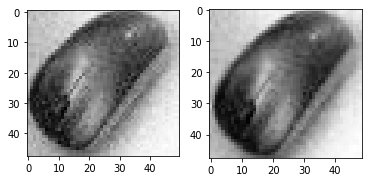

FD Rotate(2.0):mean(1.661), median(1.246) in 0.002


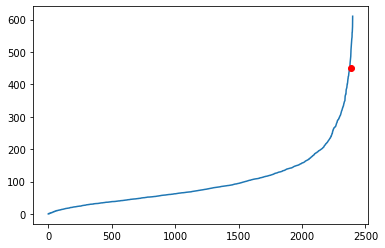

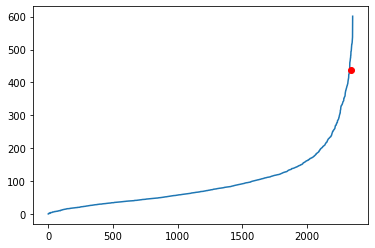

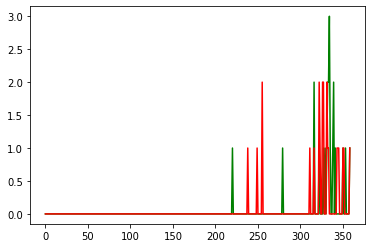

The HoG estimation when (2.0) is  7 in 0.4083s
----------------------------------------------------------------------------------------------------
The whole process time: 0.0125s = 0.0024s + 0.0097s + 0.0004s
The whole process time: 0.0123s = 0.0024s + 0.0096s + 0.0003s
The Detection vector is
[[     211.24       35.37      261.66      83.198     0.93894      0.9988          64]]
[[     203.06      39.282      253.36       86.95     0.93607     0.99937          64]]
The clipping image size is :(48, 50) (47, 50)


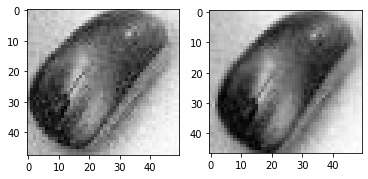

FD Rotate(3.0):mean(2.947), median(2.482) in 0.002


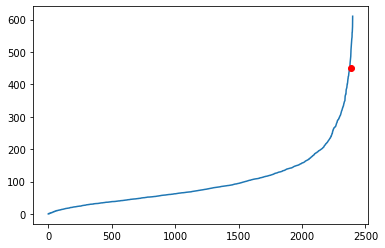

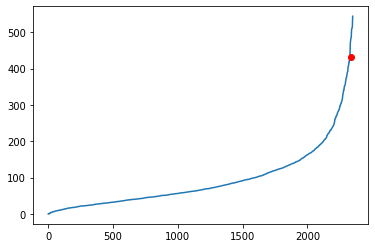

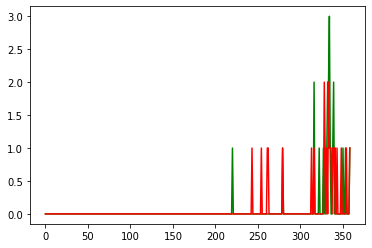

The HoG estimation when (3.0) is  0 in 0.4104s
----------------------------------------------------------------------------------------------------
The whole process time: 0.0125s = 0.0024s + 0.0098s + 0.0004s
The whole process time: 0.0125s = 0.0024s + 0.0097s + 0.0003s
The Detection vector is
[[     211.24       35.37      261.66      83.198     0.93894      0.9988          64]]
[[      201.8       40.56      252.44      89.063     0.75482     0.99859          64]]
The clipping image size is :(48, 50) (49, 51)


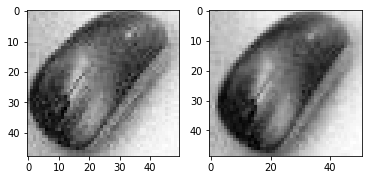

FD Rotate(4.0):mean(3.886), median(3.360) in 0.002


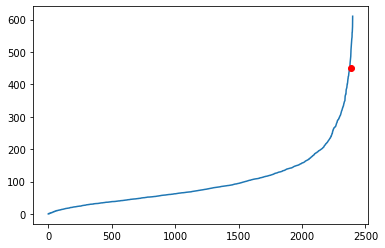

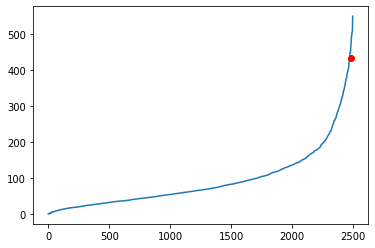

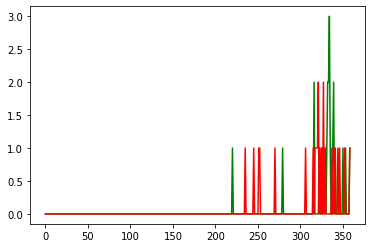

The HoG estimation when (4.0) is 14 in 0.4290s
----------------------------------------------------------------------------------------------------
The whole process time: 0.0125s = 0.0024s + 0.0098s + 0.0004s
The whole process time: 0.0124s = 0.0024s + 0.0097s + 0.0003s
The Detection vector is
[[     211.24       35.37      261.66      83.198     0.93894      0.9988          64]]
[[     200.56      41.644      250.12      91.867     0.87395     0.99887          64]
 [     395.05      1.8143         640      197.35      0.5408     0.65302          24]]
The clipping image size is :(48, 50) (50, 50)


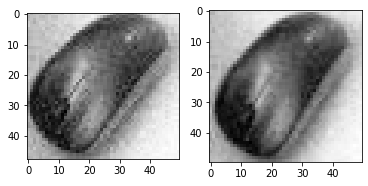

FD Rotate(5.0):mean(4.188), median(3.859) in 0.002


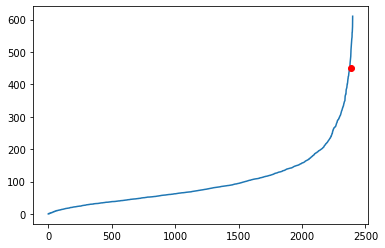

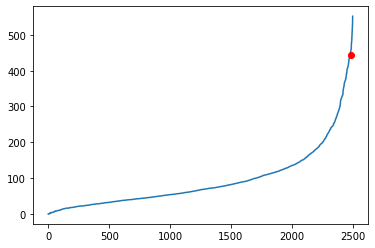

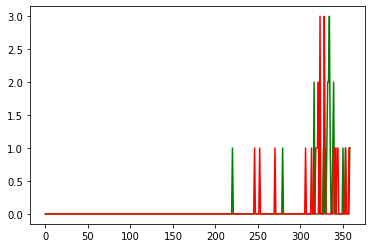

The HoG estimation when (5.0) is 11 in 0.4151s
----------------------------------------------------------------------------------------------------
The whole process time: 0.0124s = 0.0023s + 0.0098s + 0.0003s
The whole process time: 0.0132s = 0.0029s + 0.0100s + 0.0003s
The Detection vector is
[[     211.24       35.37      261.66      83.198     0.93894      0.9988          64]]
[[     198.77      42.827      249.27      94.839     0.89568     0.99855          64]]
The clipping image size is :(48, 50) (52, 51)


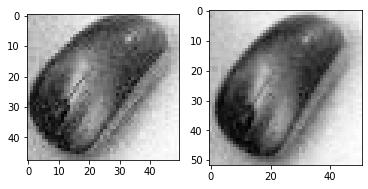

FD Rotate(6.0):mean(4.833), median(4.337) in 0.002


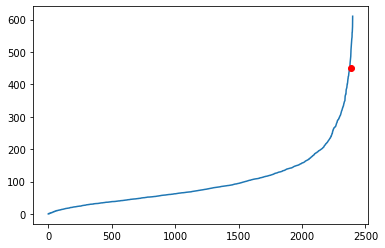

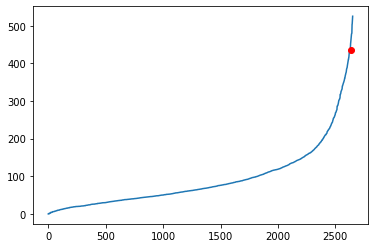

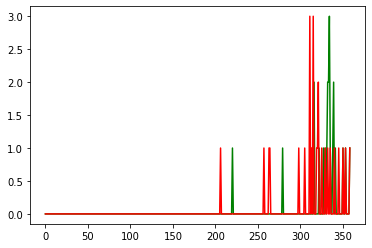

The HoG estimation when (6.0) is 14 in 0.4103s
----------------------------------------------------------------------------------------------------
The whole process time: 0.0125s = 0.0023s + 0.0098s + 0.0004s
The whole process time: 0.0129s = 0.0024s + 0.0102s + 0.0003s
The Detection vector is
[[     211.24       35.37      261.66      83.198     0.93894      0.9988          64]]
[[     198.12      44.392      243.82      95.518     0.90845     0.99713          64]
 [     389.09     0.48006      639.96      195.12     0.53043     0.71389           0]]
The clipping image size is :(48, 50) (51, 45)


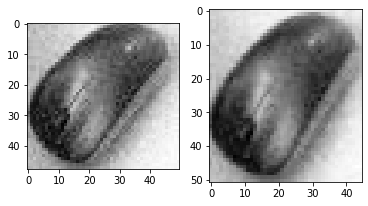

FD Rotate(7.0):mean(5.452), median(5.655) in 0.002


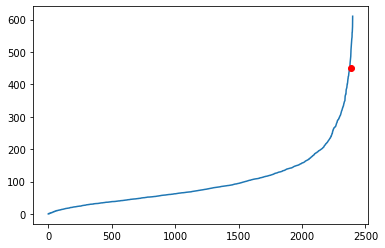

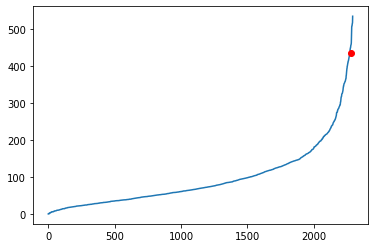

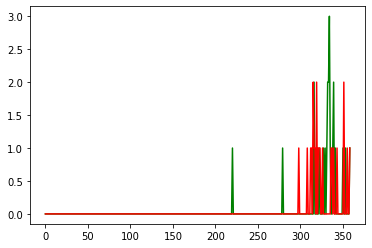

The HoG estimation when (7.0) is 15 in 0.4344s
----------------------------------------------------------------------------------------------------
The whole process time: 0.0126s = 0.0025s + 0.0098s + 0.0003s
The whole process time: 0.0124s = 0.0023s + 0.0097s + 0.0003s
The Detection vector is
[[     211.24       35.37      261.66      83.198     0.93894      0.9988          64]]
[[     196.51       45.86       241.6      97.061     0.97515     0.99814          64]
 [     388.53      1.8984       638.9      198.01     0.58512     0.88338           0]]
The clipping image size is :(48, 50) (52, 45)


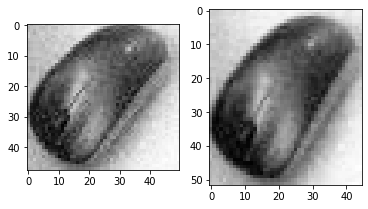

FD Rotate(8.0):mean(7.565), median(7.061) in 0.002


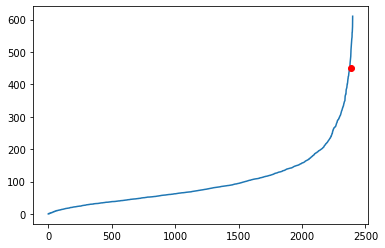

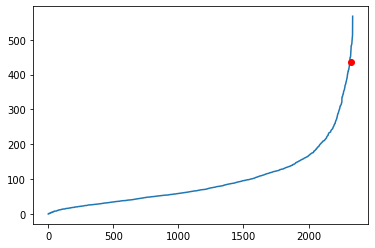

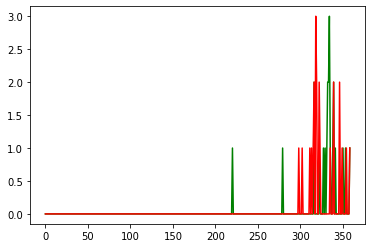

The HoG estimation when (8.0) is 14 in 0.4080s
----------------------------------------------------------------------------------------------------
[   0.017273     0.33926    0.052811     0.11422     0.81246      1.1666      1.5482     0.43491]


In [6]:
import matplotlib.pyplot as plt

base_file = 'figures/71_noise_8.jpg'

img_orig = cv2.imread(base_file)
(h, w, d) = img_orig.shape
center = (w / 2, h / 2)
detection_index = 0

errors = np.array([])

for rotate_angle in range(1, 9):
    M = cv2.getRotationMatrix2D(center, rotate_angle, 1)
    img_rotate = cv2.warpAffine(img_orig, M, (w, h))
    start = time.time()
    detection_base = object_detection(model, img_orig).cpu().numpy()
    detection_rotate = object_detection(model, img_rotate).cpu().numpy()
    
    print("The Detection vector is")
    print(detection_base)
    print(detection_rotate)
    
    img_base, img_rotate = object_capture(img_orig, img_rotate, detection_index = detection_index,
                   detection_base = detection_base, detection_rotate = detection_rotate)
    img_base = cv2.cvtColor(img_base, cv2.COLOR_BGR2GRAY)
    img_rotate = cv2.cvtColor(img_rotate, cv2.COLOR_BGR2GRAY)
    print("The clipping image size is ", end = ':')
    print(img_base.shape, img_rotate.shape)
    
    
    plt.subplot(1, 2, 1)
    plt.imshow(img_base, cmap= 'Greys_r')
    plt.subplot(1, 2, 2)
    plt.imshow(img_rotate, cmap= 'Greys_r')
    plt.show()
    
    mode = "SIFT"
    fd_median, fd_mean, exe_time = angle_cal(img_base, img_rotate, mode, show_results= show_results, show_images= show_images)
    print("FD Rotate({0:3.1f}):mean({1:5.3f}), median({2:5.3f}) in {3:.3f}".format(rotate_angle, fd_mean, fd_median, exe_time))
    
    errors = np.append(errors, abs(rotate_angle - fd_mean))
    
    bins = 360
    thres = 150
    # The translation angles
    angle_limits = 15
    
    
    
    hist_base = HoG_cal(img_base, mag_thres= thres, bin_num= bins)
    hist_rotate = HoG_cal(img_rotate, mag_thres= thres, bin_num= bins)
    plt.plot(hist_base, 'g', label = 'Orientation Historgram of Original Image')
    plt.plot(hist_rotate, 'r', label = 'Orientation Historgram of Rotate Image')
    plt.show()
    # Using HoG to calculate the angel
    angle = angle_HoG(hist_base, hist_rotate, limits = angle_limits)
    print("The HoG estimation when ({0:.1f}) is {1:2d} in {2:.4f}s" \
        .format(rotate_angle ,angle, time.time() - start))
    
    print("-" * 100)
    
print(errors)

<font face='Ubuntu' size = 4>
    
## Real images with angles

### Whole image

['figures/real_experiment/02.jpeg', 'figures/real_experiment/04.jpeg', 'figures/real_experiment/06.jpeg', 'figures/real_experiment/08.jpeg', 'figures/real_experiment/10.jpeg']
figures/real_experiment/00.jpeg


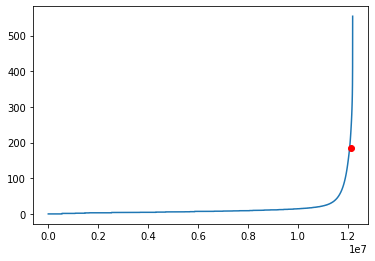

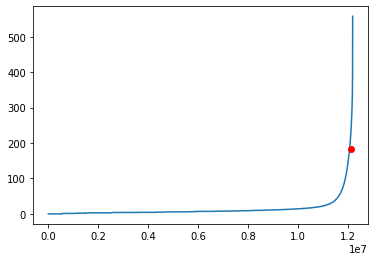

The HoG estimation when (2.0) is -2 in 4.8681s


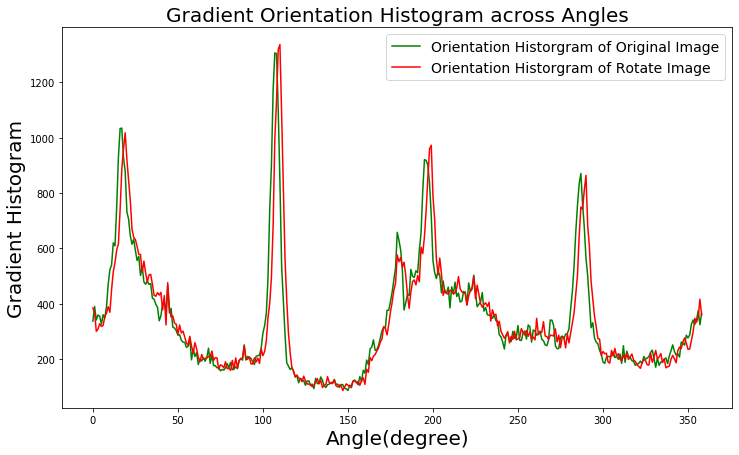

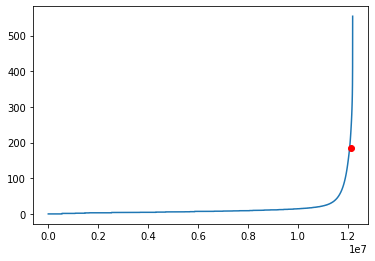

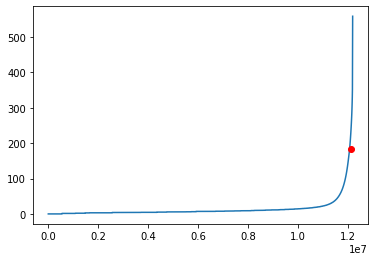

The HoG estimation when (4.0) is -4 in 4.8585s


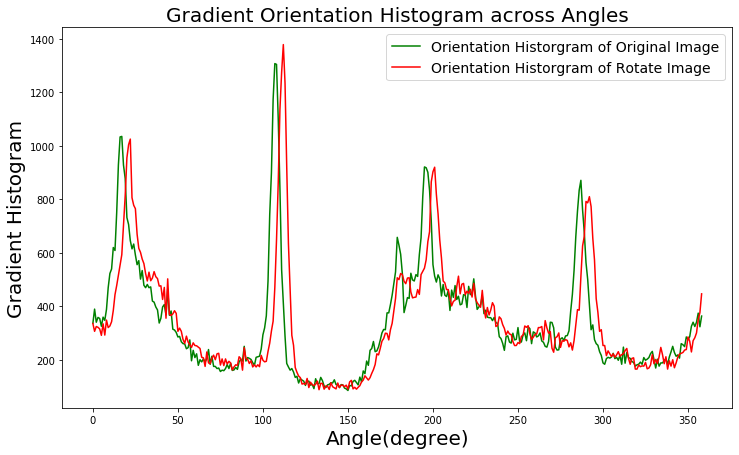

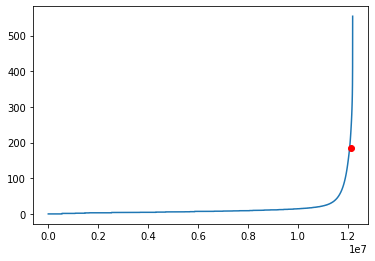

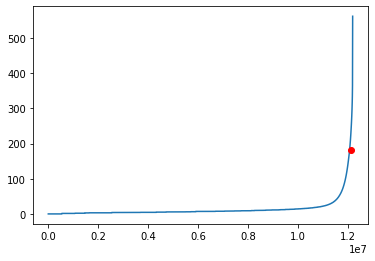

The HoG estimation when (6.0) is -6 in 4.7234s


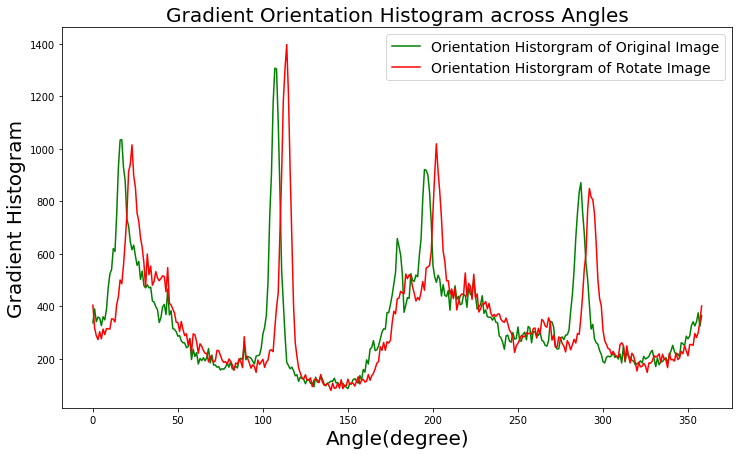

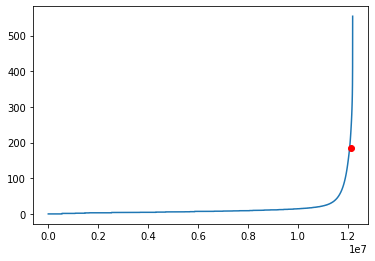

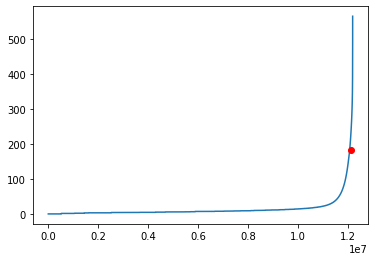

The HoG estimation when (8.0) is -8 in 4.7193s


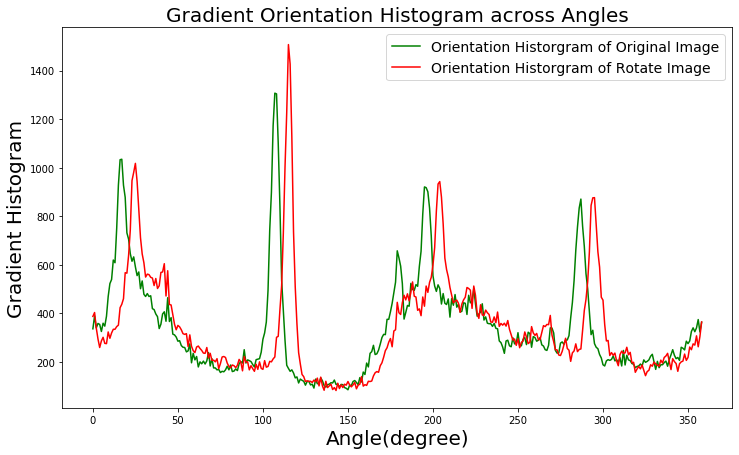

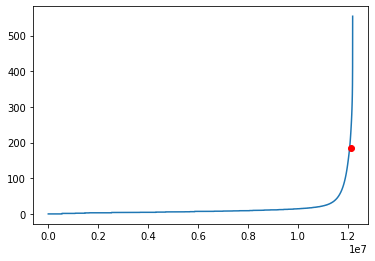

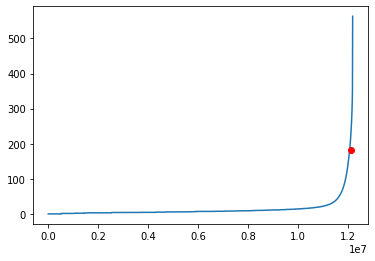

The HoG estimation when (10.0) is -10 in 4.6901s


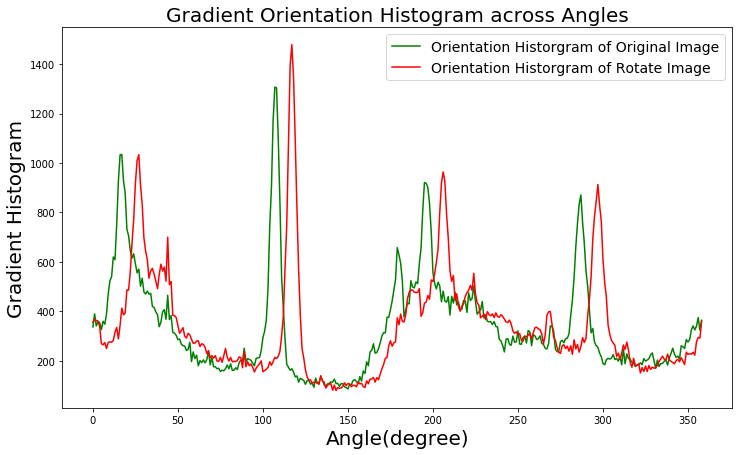

In [7]:
import glob
import os

path = 'figures/real_experiment'
files = []
files = sorted(glob.glob(os.path.join(path, '*.*')))

base_file = files.pop(0)

print(files)
print(base_file)

angles = []

bins = 360
thres = 150
# The translation angles
angle_limits = 15

for i, rotate_file in enumerate(files):
    img_base = cv2.imread(base_file, cv2.IMREAD_GRAYSCALE)
    img_rotate = cv2.imread(rotate_file, cv2.IMREAD_GRAYSCALE)
    angle_real = int(rotate_file[-7:-5])
    
    start = time.time()
    
    img_base = cv2.GaussianBlur(img_base, (5,5), 0)
    img_rotate = cv2.GaussianBlur(img_rotate, (5,5), 0)

    hist_base = HoG_cal(img_base, mag_thres= thres, bin_num= bins)
    hist_rotate = HoG_cal(img_rotate, mag_thres= thres, bin_num= bins)
    
    plt.figure(figsize= (12, 7))
    plt.plot(hist_base, 'g', label = 'Orientation Historgram of Original Image')
    plt.plot(hist_rotate, 'r', label = 'Orientation Historgram of Rotate Image')
    plt.legend(fontsize = 14)
    plt.xlabel('Angle(degree)', fontsize = 20)
    plt.ylabel('Gradient Histogram', fontsize = 20)
    plt.title("Gradient Orientation Histogram across Angles", fontsize = 20)

    # Using HoG to calculate the angel
    angle_predict = angle_HoG(hist_base, hist_rotate, limits = angle_limits)
    
    print("The HoG estimation when ({0:.1f}) is {1:2d} in {2:.4f}s" \
        .format(angle_real ,angle_predict, time.time() - start))

    plt.show()

### Local Region

In [17]:
for i, rotate_file in enumerate(files):
    
    angle_real = int(rotate_file[-7:-5])
    
    start = time.time()
    # Detection Process Transform tensor into numpy array
    if device == torch.device("cpu"):
        detection_base = object_detection(model, base_file).numpy()
        detection_rotate = object_detection(model, rotate_file).numpy()
    else:
        detection_base = object_detection(model, base_file, conf_thres= 0.05).cpu().numpy()
        detection_rotate = object_detection(model, rotate_file, conf_thres= 0.05).cpu().numpy()
    print("Detection time comsuming: {0:.4f}".format(time.time() - start))

    print("The Detection vector is")
    print(detection_base)
    print(detection_rotate)
    
    
    # Image Orientation Calculation
    show_results = False
    show_images = False
    # The index of object using to calculation the capture image
    detection_index = 1

    img_base, img_rotate = object_capture(base_file, rotate_file, detection_index = detection_index,
                       detection_base = detection_base, detection_rotate = detection_rotate)
    
    img_base = cv2.cvtColor(img_base, cv2.COLOR_BGR2GRAY)
    img_rotate = cv2.cvtColor(img_rotate, cv2.COLOR_BGR2GRAY)
    print("The clipping image size is ", end = ':')
    print(img_base.shape, img_rotate.shape)
    
    
    plt.subplot(1, 2, 1)
    plt.imshow(img_base, cmap= 'Greys_r')
    plt.subplot(1, 2, 2)
    plt.imshow(img_rotate, cmap= 'Greys_r')
    plt.show()
    
    mode = "SIFT"
    fd_median, fd_mean, exe_time = angle_cal(img_base, img_rotate, mode, show_results= show_results, show_images= show_images)
    print("FD Rotate({0:3.1f}):mean({1:5.3f}), median({2:5.3f}) in {3:.3f}".format(rotate_angle, fd_mean, fd_median, exe_time))
    
    bins = 360
    thres = 150
    # The translation angles
    angle_limits = 15
    
    hist_base = HoG_cal(img_base, mag_thres= thres, bin_num= bins)
    hist_rotate = HoG_cal(img_rotate, mag_thres= thres, bin_num= bins)
    plt.plot(hist_base, 'g', label = 'Orientation Historgram of Original Image')
    plt.plot(hist_rotate, 'r', label = 'Orientation Historgram of Rotate Image')
    plt.show()
    # Using HoG to calculate the angel
    angle = angle_HoG(hist_base, hist_rotate, limits = angle_limits)
    print("The HoG result is {0:2d} in {1:.4f}".format(Hog_angle, time.time() - start))
    
    print("-" * 100)

The whole process time: 0.1382s = 0.1034s + 0.0345s + 0.0003s
The whole process time: 0.1115s = 0.0993s + 0.0119s + 0.0003s
Detection time comsuming: 0.2502
The Detection vector is
[[          0      1744.6      458.53      3041.9     0.19877     0.99008           0]
 [     1793.5      2444.3        2699      3592.1     0.11582     0.69728          62]
 [          0      1761.1      493.34      2216.3    0.095935     0.72788           0]
 [     1258.8      3364.9      1827.3      3710.6    0.051484     0.53294          39]]
[[     1711.6        2452      2635.1      3647.1     0.16792     0.82959          62]
 [       1145      3338.2      1788.1      3714.5     0.14716     0.78295          39]
 [          0        1718      489.43      2166.8    0.054567     0.43989           0]]


/home/johnpaul/.conda/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


ValueError: not enough values to unpack (expected 4, got 1)

In [15]:
a = np.array([4, 3, 6])
b = np.array([8, 24, 4])

inters = np.intersect1d(a, b)
d = np.where(a == inters)
f = np.where(b == inters)

print(inters)
print(d)
print(f)

[4]
(array([0]),)
(array([2]),)
